## DAS visualization

In [1]:
# import necessary dependencies
import scipy, datetime, sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
sys.path.append("../utils/")
import DASfuncs

In [2]:
# define path
root = Path.cwd().parent
DAS_path = os.path.join(root, 'data', 'DAS', 'data_1HZ')

In [3]:
# define time 
t_start = datetime.datetime(2023,8,11) # from Aug 9-29
t_end = datetime.datetime(2023,8,12)

In [4]:
# get files
files = DASfuncs.get_Onyx_h5(DAS_path, t_start, t_end)
n = len(files)
print(f'{n} files in directory')

25 files in directory


In [5]:
# read the data
time_read, data_read, attrs_read = DASfuncs.read_Onyx_h5_to_list(files, cha_start=None, cha_end=None, t_start=t_start, t_end=t_end, verbose=True)
# concatenate files
t_rec, data_rec, attrs = DASfuncs.comb_Onyx_data(time_read, data_read, attrs_read)

Problems with: /Users/suphakornpoobua/Desktop/DAS_project/data/DAS/data_1HZ/decimator3_2023-08-24_22.13.10_UTC.h5
zero-size array to reduction operation maximum which has no identity


In [6]:
# fill contiuous parts of data into array
time_list, data_list = DASfuncs.split_continuous_data(t_rec, data_rec, attrs)
# fill data gaps in array
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, data_list, attrs, t_format='datetime')

In [7]:
# filtering
sos = scipy.signal.butter(2, 0.1,'lowpass', fs=attrs['PulseRate'], output='sos')
filt_list = [DASfuncs.apply_sosfiltfilt_with_nan(sos, arr, axis=0) for arr in data_list]

In [8]:
times_filled, data_filled = DASfuncs.fill_data_gaps(time_list, filt_list, attrs, t_format='datetime')

In [9]:
data_arr = data_filled
times = DASfuncs.sintela_to_datetime(t_rec)  # Convert timestamp to datetime
dx = attrs['GaugeLength']
chas = np.arange(attrs['StartLocusIndex'], attrs['StartLocusIndex']+attrs['NumberOfLoci'])
dists = chas*dx

In [10]:
attrs

{'AcquisitionId': b'RunName/RunNumber',
 'BandDataMaxUserValue': 0.0,
 'BandDataMinUserValue': 0.0,
 'Build': b'5.19.6_P',
 'CommitHash': b'e0de8303',
 'DasInstrumentBox': b'ONYXONYX-0186',
 'DetectionAccuracy': b'Not Applicable',
 'FFID': 0,
 'FacilityId': b'WellName1',
 'FiberID': 1,
 'GaugeLength': 4.785714402601981,
 'GaugeLengthUnit': b'm',
 'Hostname': b'ONYX-0186',
 'MaximumFrequency': 0.5,
 'MeasurementStartTime': b'2023-08-11T00:02:22.000000+00:00',
 'MinimumFrequency': 0.0,
 'NumberOfLoci': 1135,
 'OpticalPath': b'OpticalPath',
 'PulseRate': 1.0,
 'PulseRateUnit': b'Hz',
 'PulseWidth': 20.0,
 'PulseWidthUnit': b'ns',
 'SoftwareVersion': b'7320',
 'SpatialSamplingInterval': 4.785714402601981,
 'SpatialSamplingIntervalUnit': b'm',
 'StartLocusIndex': 0,
 'SystemType': b'Xavier',
 'TriggeredMeasurement': 0,
 'VendorCode': b'Vendor',
 'schemaVersion': b'2.0',
 'uuid': b'08ef01c0-869f-47e0-8457-05a26a94b499'}

In [11]:
# Slice data in time and space
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = t_start
end_time = t_end#t_start+datetime.timedelta(hours=12)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = data_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]

In [12]:
data_norm = plot_arr #- np.nanmedian(plot_arr, axis=0)
# data_norm = data_norm / np.std(data_norm, axis=0)[None,:]

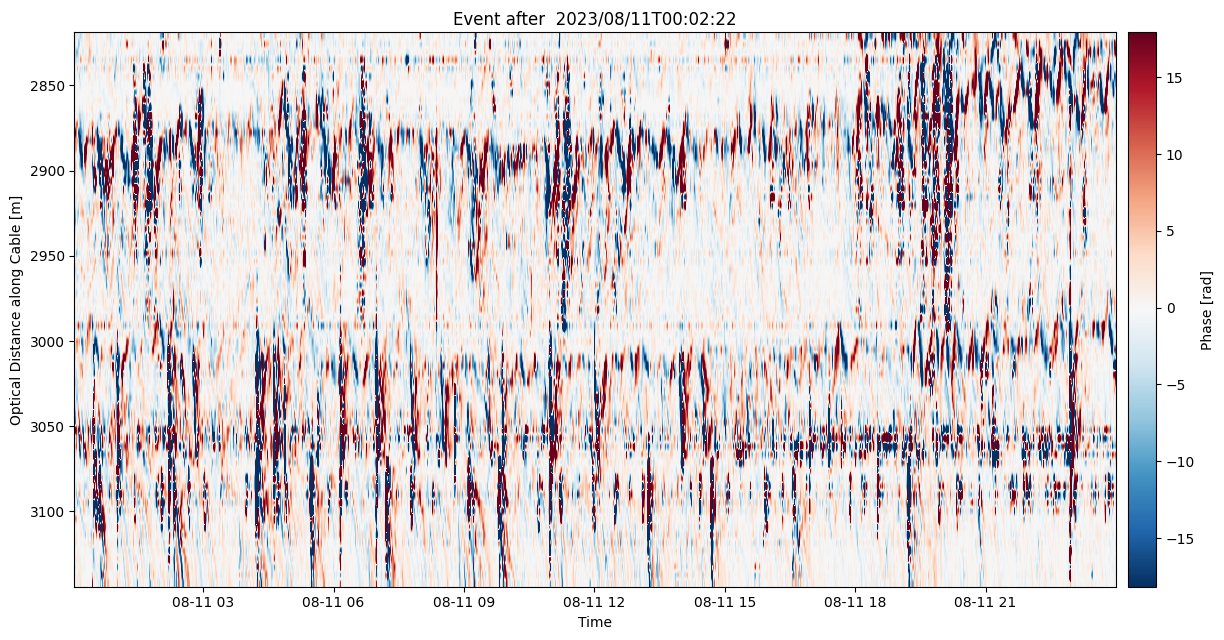

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))

im = ax.imshow(data_norm.T, aspect='auto',
             origin='lower',
             vmin=np.percentile(data_norm[~np.isnan(data_norm)],5),
             vmax=np.percentile(data_norm[~np.isnan(data_norm)],95),
             extent=[plot_times[0], plot_times[-1],
                  plot_dists[0], plot_dists[-1]],
             cmap='RdBu_r', # or cmap = 'seismic'
             # interpolation='none',
               zorder=0
             )

ax.set_ylabel('Optical Distance along Cable [m]')
ax.set_xlabel('Time')
ax.set_title('Event after  {}'.format(plot_times[0].strftime("%Y/%m/%dT%H:%M:%S")))
ax.invert_yaxis()

cbar = fig.colorbar(im, pad=0.01)
cbar.set_label('Phase [rad]')